In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.set_loglevel("info")

In [34]:
# Input files
df_file = "results/full/cc_trembl/evaluation_all.tsv"
out_folder = "results/full/cc_trembl/"

# Set to None if you don't want to use it. Results will not be grouped/filtered by team
names_file = {
  'filename': ['naive.tsv', 'deepgose.tsv', 'diamond.tsv', 'netgo3.tsv', 'sprof.tsv', 
               'tale.tsv', 'transfew.tsv'],
  'group': ['naive', 'deepgose', 'diamond', 'netgo3', 'sprof', 
               'tale', 'transfew'],
  'label': ['Naive', 'DeepGO-SE', 'Diamond', 'NetGO 3.0', 'SPROF-GO', 
               'Tale', 'Transfew'],
}

# Cumulate the last column of the cols variable, e.g. "pr" --> precision, so that the curves are monotonic as in CAFA
cumulate = True

# Add extreme points to the precision-recall curves (0, 1) and (1, 0)
add_extreme_points = True

# Methods with coverage below this threshold will not be plotted
coverage_threshold = 0.3

# Select a metric
metric, cols = ('f', ['rc', 'pr'])
# metric, cols =  ('f_w', ['rc_w', 'pr_w'])
# metric, cols =  ('f_micro', ['rc_micro', 'pr_micro'])
# metric, cols =  ('f_micro_w', ['rc_micro_w', 'pr_micro_w'])
# metric, cols = ('s_w', ['ru_w', 'mi_w'])

In [35]:
# Map column names to full names (for axis labels)
axis_title_dict = {'pr': 'Precision', 'rc': 'Recall', 'f': 'F-score', 'pr_w': 'Weighted Precision', 'rc_w': 'Weighted Recall', 'f_w': 'Weighted F-score', 'mi': 'Misinformation (Unweighted)', 'ru': 'Remaining Uncertainty (Unweighted)', 'mi_w': 'Misinformation', 'ru_w': 'Remaining Uncertainty', 's': 'S-score', 'pr_micro': 'Precision (Micro)', 'rc_micro': 'Recall (Micro)', 'f_micro': 'F-score (Micro)', 'pr_micro_w': 'Weighted Precision (Micro)', 'rc_micro_w': 'Weighted Recall (Micro)', 'f_micro_w': 'Weighted F-score (Micro)'}

# Map ontology namespaces to full names (for plot titles)
ontology_dict = {'biological_process': 'Biological Process', 'molecular_function': 'Molecular Function', 'cellular_component': 'Cellular Component'}

In [36]:
df = pd.read_csv(df_file, sep="\t")
df

,filename,ns,tau,cov,pr,rc,f,wcov,pr_w,rc_w,f_w,mi,ru,s
0,transfew.tsv,cellular_component,0.01,1.00000,0.28587,0.90872,0.43492,1.00000,0.18461,0.87410,0.30484,50.74611,2.03915,50.78707
1,transfew.tsv,cellular_component,0.02,1.00000,0.32925,0.89312,0.48113,1.00000,0.22043,0.85243,0.35028,37.88857,2.35744,37.96184
2,transfew.tsv,cellular_component,0.03,1.00000,0.35883,0.88282,0.51026,1.00000,0.24840,0.83752,0.38316,31.66729,2.54533,31.76942
3,transfew.tsv,cellular_component,0.04,1.00000,0.38086,0.87684,0.53105,1.00000,0.26989,0.82801,0.40709,27.68422,2.68137,27.81377
4,transfew.tsv,cellular_component,0.05,1.00000,0.39847,0.87156,0.54690,1.00000,0.28472,0.81947,0.42261,24.92655,2.81370,25.08485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,combined.tsv,cellular_component,0.95,0.96419,0.83550,0.53995,0.65597,0.96419,0.75959,0.36534,0.49338,2.08374,7.04678,7.34841
491,combined.tsv,cellular_component,0.96,0.96036,0.84703,0.52422,0.64763,0.96036,0.77677,0.34476,0.47756,1.86503,7.19362,7.43145
492,combined.tsv,cellular_component,0.97,0.94629,0.85755,0.50026,0.63190,0.94629,0.78943,0.31999,0.45539,1.71633,7.35867,7.55618
493,combined.tsv,cellular_component,0.98,0.92327,0.87370,0.46713,0.60877,0.92327,0.81289,0.28886,0.42625,1.51692,7.65737,7.80618


In [37]:
# Set method information (optional)
if names_file is None:
    df['group'] = df['filename']
    df['label'] = df['filename']
    df['is_baseline'] = False
else:
    # methods = pd.read_csv(names_file, delim_whitespace=True, header=0)
    # methods  = pd.DataFrame.from_dict(data)
    methods = pd.DataFrame.from_dict(names_file)
    df = pd.merge(df, methods, on='filename', how='left')
    df['group'].fillna(df['filename'], inplace=True)
    df['label'].fillna(df['filename'], inplace=True)
    if 'is_baseline' not in df:
        df['is_baseline'] = False
    else:
        df['is_baseline'].fillna(False, inplace=True)
    # print(methods)
df = df.drop(columns='filename').set_index(['group', 'label', 'ns', 'tau'])
df

cov       pr       rc  \
group        label        ns                 tau                               
transfew     Transfew     cellular_component 0.01  1.00000  0.28587  0.90872   
                                             0.02  1.00000  0.32925  0.89312   
                                             0.03  1.00000  0.35883  0.88282   
                                             0.04  1.00000  0.38086  0.87684   
                                             0.05  1.00000  0.39847  0.87156   
...                                                    ...      ...      ...   
combined.tsv combined.tsv cellular_component 0.95  0.96419  0.83550  0.53995   
                                             0.96  0.96036  0.84703  0.52422   
                                             0.97  0.94629  0.85755  0.50026   
                                             0.98  0.92327  0.87370  0.46713   
                                             0.99  0.86317  0.89814  0.40897   

                                                         f     wcov     pr_w  \
group        label        ns                 tau                               
transfew     Transfew     cellular_component 0.01  0.43492  1.00000  0.18461   
                                             0.02  0.48113  1.00000  0.22043   
                                             0.03  0.51026  1.00000  0.24840   
                                             0.04  0.53105  1.00000  0.26989   
                                             0.05  0.54690  1.00000  0.28472   
...                                                    ...      ...      ...   
combined.tsv combined.tsv cellular_component 0.95  0.65597  0.96419  0.75959   
                                             0.96  0.64763  0.96036  0.77677   
                                             0.97  0.63190  0.94629  0.78943   
                                             0.98  0.60877  0.92327  0.81289   
                                             0.99  0.56202  0.86317  0.84873   

                                                      rc_w      f_w        mi  \
group        label        ns                 tau                                
transfew     Transfew     cellular_component 0.01  0.87410  0.30484  50.74611   
                                             0.02  0.85243  0.35028  37.88857   
                                             0.03  0.83752  0.38316  31.66729   
                                             0.04  0.82801  0.40709  27.68422   
                                             0.05  0.81947  0.42261  24.92655   
...                                                    ...      ...       ...   
combined.tsv combined.tsv cellular_component 0.95  0.36534  0.49338   2.08374   
                                             0.96  0.34476  0.47756   1.86503   
                                             0.97  0.31999  0.45539   1.71633   
                                             0.98  0.28886  0.42625   1.51692   
                                             0.99  0.23421  0.36711   1.11363   

                                                        ru         s  \
group        label        ns                 tau                       
transfew     Transfew     cellular_component 0.01  2.03915  50.78707   
                                             0.02  2.35744  37.96184   
                                             0.03  2.54533  31.76942   
                                             0.04  2.68137  27.81377   
                                             0.05  2.81370  25.08485   
...                                                    ...       ...   
combined.tsv combined.tsv cellular_component 0.95  7.04678   7.34841   
                                             0.96  7.19362   7.43145   
                                             0.97  7.35867   7.55618   
                                             0.98  7.65737   7.80618   
                                             0.99  8.08

In [38]:
# Filter by coverage
df = df[df['cov'] >= coverage_threshold]
df

cov       pr       rc  \
group        label        ns                 tau                               
transfew     Transfew     cellular_component 0.01  1.00000  0.28587  0.90872   
                                             0.02  1.00000  0.32925  0.89312   
                                             0.03  1.00000  0.35883  0.88282   
                                             0.04  1.00000  0.38086  0.87684   
                                             0.05  1.00000  0.39847  0.87156   
...                                                    ...      ...      ...   
combined.tsv combined.tsv cellular_component 0.95  0.96419  0.83550  0.53995   
                                             0.96  0.96036  0.84703  0.52422   
                                             0.97  0.94629  0.85755  0.50026   
                                             0.98  0.92327  0.87370  0.46713   
                                             0.99  0.86317  0.89814  0.40897   

                                                         f     wcov     pr_w  \
group        label        ns                 tau                               
transfew     Transfew     cellular_component 0.01  0.43492  1.00000  0.18461   
                                             0.02  0.48113  1.00000  0.22043   
                                             0.03  0.51026  1.00000  0.24840   
                                             0.04  0.53105  1.00000  0.26989   
                                             0.05  0.54690  1.00000  0.28472   
...                                                    ...      ...      ...   
combined.tsv combined.tsv cellular_component 0.95  0.65597  0.96419  0.75959   
                                             0.96  0.64763  0.96036  0.77677   
                                             0.97  0.63190  0.94629  0.78943   
                                             0.98  0.60877  0.92327  0.81289   
                                             0.99  0.56202  0.86317  0.84873   

                                                      rc_w      f_w        mi  \
group        label        ns                 tau                                
transfew     Transfew     cellular_component 0.01  0.87410  0.30484  50.74611   
                                             0.02  0.85243  0.35028  37.88857   
                                             0.03  0.83752  0.38316  31.66729   
                                             0.04  0.82801  0.40709  27.68422   
                                             0.05  0.81947  0.42261  24.92655   
...                                                    ...      ...       ...   
combined.tsv combined.tsv cellular_component 0.95  0.36534  0.49338   2.08374   
                                             0.96  0.34476  0.47756   1.86503   
                                             0.97  0.31999  0.45539   1.71633   
                                             0.98  0.28886  0.42625   1.51692   
                                             0.99  0.23421  0.36711   1.11363   

                                                        ru         s  \
group        label        ns                 tau                       
transfew     Transfew     cellular_component 0.01  2.03915  50.78707   
                                             0.02  2.35744  37.96184   
                                             0.03  2.54533  31.76942   
                                             0.04  2.68137  27.81377   
                                             0.05  2.81370  25.08485   
...                                                    ...       ...   
combined.tsv combined.tsv cellular_component 0.95  7.04678   7.34841   
                                             0.96  7.19362   7.43145   
                                             0.97  7.35867   7.55618   
                                             0.98  7.65737   7.80618   
                                             0.99  8.08

In [39]:
# Assign colors based on group
cmap = plt.get_cmap('tab20')
df['colors'] = df.index.get_level_values('group')
df['colors'] = pd.factorize(df['colors'])[0]
df['colors'] = df['colors'].apply(lambda x: cmap.colors[x % len(cmap.colors)])
df

cov       pr       rc  \
group        label        ns                 tau                               
transfew     Transfew     cellular_component 0.01  1.00000  0.28587  0.90872   
                                             0.02  1.00000  0.32925  0.89312   
                                             0.03  1.00000  0.35883  0.88282   
                                             0.04  1.00000  0.38086  0.87684   
                                             0.05  1.00000  0.39847  0.87156   
...                                                    ...      ...      ...   
combined.tsv combined.tsv cellular_component 0.95  0.96419  0.83550  0.53995   
                                             0.96  0.96036  0.84703  0.52422   
                                             0.97  0.94629  0.85755  0.50026   
                                             0.98  0.92327  0.87370  0.46713   
                                             0.99  0.86317  0.89814  0.40897   

                                                         f     wcov     pr_w  \
group        label        ns                 tau                               
transfew     Transfew     cellular_component 0.01  0.43492  1.00000  0.18461   
                                             0.02  0.48113  1.00000  0.22043   
                                             0.03  0.51026  1.00000  0.24840   
                                             0.04  0.53105  1.00000  0.26989   
                                             0.05  0.54690  1.00000  0.28472   
...                                                    ...      ...      ...   
combined.tsv combined.tsv cellular_component 0.95  0.65597  0.96419  0.75959   
                                             0.96  0.64763  0.96036  0.77677   
                                             0.97  0.63190  0.94629  0.78943   
                                             0.98  0.60877  0.92327  0.81289   
                                             0.99  0.56202  0.86317  0.84873   

                                                      rc_w      f_w        mi  \
group        label        ns                 tau                                
transfew     Transfew     cellular_component 0.01  0.87410  0.30484  50.74611   
                                             0.02  0.85243  0.35028  37.88857   
                                             0.03  0.83752  0.38316  31.66729   
                                             0.04  0.82801  0.40709  27.68422   
                                             0.05  0.81947  0.42261  24.92655   
...                                                    ...      ...       ...   
combined.tsv combined.tsv cellular_component 0.95  0.36534  0.49338   2.08374   
                                             0.96  0.34476  0.47756   1.86503   
                                             0.97  0.31999  0.45539   1.71633   
                                             0.98  0.28886  0.42625   1.51692   
                                             0.99  0.23421  0.36711   1.11363   

                                                        ru         s  \
group        label        ns                 tau                       
transfew     Transfew     cellular_component 0.01  2.03915  50.78707   
                                             0.02  2.35744  37.96184   
                                             0.03  2.54533  31.76942   
                                             0.04  2.68137  27.81377   
                                             0.05  2.81370  25.08485   
...                                                    ...       ...   
combined.tsv combined.tsv cellular_component 0.95  7.04678   7.34841   
                                             0.96  7.19362   7.43145   
                                             0.97  7.35867   7.55618   
                                             0.98  7.65737   7.80618   
                                             0.99  8.08

In [40]:
# Identify the best methods and thresholds
index_best = df.groupby(level=['group', 'ns'])[metric].idxmax() if metric in ['f', 'f_w', 'f_micro', 'f_micro_w'] else df.groupby(['group', 'ns'])[metric].idxmin()
index_best

group         ns                
combined.tsv  cellular_component    (combined.tsv, combined.tsv, cellular_componen...
esm2_t48.tsv  cellular_component    (esm2_t48.tsv, esm2_t48.tsv, cellular_componen...
interpro.tsv  cellular_component    (interpro.tsv, interpro.tsv, cellular_componen...
msa_1b.tsv    cellular_component    (msa_1b.tsv, msa_1b.tsv, cellular_component, 0...
transfew      cellular_component       (transfew, Transfew, cellular_component, 0.58)
Name: f_w, dtype: object

In [41]:
# Filter the dataframe for the best methods
df_methods = df.reset_index('tau').loc[[ele[:-1] for ele in index_best], ['tau', 'cov', 'colors'] + cols + [metric]].sort_index()

# Makes the curves monotonic. Cumulative max on the last column of the cols variable, e.g. "pr" --> precision
if cumulate:
    if metric in ['f', 'f_w', 'f_micro', 'f_micro_w']:
        df_methods[cols[-1]] = df_methods.groupby(level=['label', 'ns'])[cols[-1]].cummax()
    else:
        df_methods[cols[-1]] = df_methods.groupby(level=['label', 'ns'])[cols[-1]].cummin()


# Save to file
df_methods.drop(columns=['colors']).to_csv('{}/fig_{}.tsv'.format(out_folder, metric), float_format="%.3f", sep="\t")
df_methods

tau      cov  \
group        label        ns                                  
combined.tsv combined.tsv cellular_component  0.01  1.00000   
                          cellular_component  0.02  1.00000   
                          cellular_component  0.03  1.00000   
                          cellular_component  0.04  1.00000   
                          cellular_component  0.05  1.00000   
...                                            ...      ...   
transfew     Transfew     cellular_component  0.95  0.94118   
                          cellular_component  0.96  0.92455   
                          cellular_component  0.97  0.90665   
                          cellular_component  0.98  0.85422   
                          cellular_component  0.99  0.73913   

                                                                                         colors  \
group        label        ns                                                                      
combined.tsv combined.tsv cellular_component  (0.17254901960784313, 0.6274509803921569, 0.17...   
                          cellular_component  (0.17254901960784313, 0.6274509803921569, 0.17...   
                          cellular_component  (0.17254901960784313, 0.6274509803921569, 0.17...   
                          cellular_component  (0.17254901960784313, 0.6274509803921569, 0.17...   
                          cellular_component  (0.17254901960784313, 0.6274509803921569, 0.17...   
...                                                                                         ...   
transfew     Transfew     cellular_component  (0.12156862745098039, 0.4666666666666667, 0.70...   
                          cellular_component  (0.12156862745098039, 0.4666666666666667, 0.70...   
                          cellular_component  (0.12156862745098039, 0.4666666666666667, 0.70...   
                          cellular_component  (0.12156862745098039, 0.4666666666666667, 0.70...   
                          cellular_component  (0.12156862745098039, 0.4666666666666667, 0.70...   

                                                 rc_w     pr_w      f_w  
group        label        ns                                             
combined.tsv combined.tsv cellular_component  0.81468  0.27526  0.41149  
                          cellular_component  0.79148  0.31191  0.44748  
                          cellular_component  0.77862  0.33595  0.46938  
                          cellular_component  0.76925  0.35395  0.48483  
                          cellular_component  0.76237  0.36801  0.49640  
...                                               ...      ...      ...  
transfew     Transfew     cellular_component  0.31058  0.82280  0.45094  
                          cellular_component  0.28853  0.83185  0.42845  
                          cellular_component  0.26046  0.85588  0.39938  
                          cellular_component  0.21546  0.87385  0.34569  
                          cellular_component  0.15377  0.89219  0.26233  

[495 rows x 6 columns]

In [42]:
# Add first last points to precision and recall curves to improve APS calculation
def add_points(df_):
    df_ = pd.concat([df_.iloc[0:1], df_])
    df_.iloc[0, df_.columns.get_indexer(['tau', cols[0], cols[1]])] = [0, 1, 0]  # tau, rc, pr
    df_ = pd.concat([df_, df_.iloc[-1:]])
    df_.iloc[-1, df_.columns.get_indexer(['tau', cols[0], cols[1]])] = [1.1, 0, 1]
    return df_

if metric.startswith('f') and add_extreme_points:
    df_methods = df_methods.reset_index().groupby(['group', 'label', 'ns'], as_index=False).apply(add_points).set_index(['group', 'label', 'ns'])
df_methods

tau      cov  \
group        label        ns                                  
combined.tsv combined.tsv cellular_component  0.00  1.00000   
                          cellular_component  0.01  1.00000   
                          cellular_component  0.02  1.00000   
                          cellular_component  0.03  1.00000   
                          cellular_component  0.04  1.00000   
...                                            ...      ...   
transfew     Transfew     cellular_component  0.96  0.92455   
                          cellular_component  0.97  0.90665   
                          cellular_component  0.98  0.85422   
                          cellular_component  0.99  0.73913   
                          cellular_component  1.10  0.73913   

                                                                                         colors  \
group        label        ns                                                                      
combined.tsv combined.tsv cellular_component  (0.17254901960784313, 0.6274509803921569, 0.17...   
                          cellular_component  (0.17254901960784313, 0.6274509803921569, 0.17...   
                          cellular_component  (0.17254901960784313, 0.6274509803921569, 0.17...   
                          cellular_component  (0.17254901960784313, 0.6274509803921569, 0.17...   
                          cellular_component  (0.17254901960784313, 0.6274509803921569, 0.17...   
...                                                                                         ...   
transfew     Transfew     cellular_component  (0.12156862745098039, 0.4666666666666667, 0.70...   
                          cellular_component  (0.12156862745098039, 0.4666666666666667, 0.70...   
                          cellular_component  (0.12156862745098039, 0.4666666666666667, 0.70...   
                          cellular_component  (0.12156862745098039, 0.4666666666666667, 0.70...   
                          cellular_component  (0.12156862745098039, 0.4666666666666667, 0.70...   

                                                 rc_w     pr_w      f_w  
group        label        ns                                             
combined.tsv combined.tsv cellular_component  1.00000  0.00000  0.41149  
                          cellular_component  0.81468  0.27526  0.41149  
                          cellular_component  0.79148  0.31191  0.44748  
                          cellular_component  0.77862  0.33595  0.46938  
                          cellular_component  0.76925  0.35395  0.48483  
...                                               ...      ...      ...  
transfew     Transfew     cellular_component  0.28853  0.83185  0.42845  
                          cellular_component  0.26046  0.85588  0.39938  
                          cellular_component  0.21546  0.87385  0.34569  
                          cellular_component  0.15377  0.89219  0.26233  
                          cellular_component  0.00000  1.00000  0.26233  

[505 rows x 6 columns]

In [43]:
# Filter the dataframe for the best method and threshold
df_best = df.loc[index_best, ['cov', 'colors'] + cols + [metric]]
df_best

,,,,cov,colors,rc_w,pr_w,f_w
group,label,ns,tau,,,,,
combined.tsv,combined.tsv,cellular_component,0.57,0.99872,"(0.17254901960784313, 0.6274509803921569, 0.17...",0.59358,0.58071,0.58708
esm2_t48.tsv,esm2_t48.tsv,cellular_component,0.37,1.00000,"(0.6823529411764706, 0.7803921568627451, 0.909...",0.62052,0.59169,0.60576
interpro.tsv,interpro.tsv,cellular_component,0.34,1.00000,"(1.0, 0.7333333333333333, 0.47058823529411764)",0.54888,0.53063,0.53960
msa_1b.tsv,msa_1b.tsv,cellular_component,0.37,1.00000,"(1.0, 0.4980392156862745, 0.054901960784313725)",0.55146,0.58182,0.56623
transfew,Transfew,cellular_component,0.58,1.00000,"(0.12156862745098039, 0.4666666666666667, 0.70...",0.62662,0.59585,0.61085


In [44]:
# Calculate average precision score 
if metric.startswith('f'):
    df_best['aps'] = df_methods.groupby(level=['group', 'label', 'ns'])[[cols[0], cols[1]]].apply(lambda x: (x[cols[0]].diff(-1).shift(1) * x[cols[1]]).sum())
df_best
df_best.to_csv('{}/aps.tsv'.format(out_folder), float_format="%.4f", sep="\t")

In [45]:
# Calculate the max coverage across all thresholds
df_best['max_cov'] = df_methods.groupby(level=['group', 'label', 'ns'])['cov'].max()
df_best

,,,,cov,colors,rc_w,pr_w,f_w,aps,max_cov
group,label,ns,tau,,,,,,,
combined.tsv,combined.tsv,cellular_component,0.57,0.99872,"(0.17254901960784313, 0.6274509803921569, 0.17...",0.59358,0.58071,0.58708,0.645378,1.0
esm2_t48.tsv,esm2_t48.tsv,cellular_component,0.37,1.00000,"(0.6823529411764706, 0.7803921568627451, 0.909...",0.62052,0.59169,0.60576,0.642913,1.0
interpro.tsv,interpro.tsv,cellular_component,0.34,1.00000,"(1.0, 0.7333333333333333, 0.47058823529411764)",0.54888,0.53063,0.53960,0.558518,1.0
msa_1b.tsv,msa_1b.tsv,cellular_component,0.37,1.00000,"(1.0, 0.4980392156862745, 0.054901960784313725)",0.55146,0.58182,0.56623,0.594238,1.0
transfew,Transfew,cellular_component,0.58,1.00000,"(0.12156862745098039, 0.4666666666666667, 0.70...",0.62662,0.59585,0.61085,0.644065,1.0


In [46]:
# Set a label column for the plot legend
df_best['label'] = df_best.index.get_level_values('label')
if 'aps' not in df_best.columns:
    df_best['label'] = df_best.agg(lambda x: f"{x['label']} ({metric.upper()}={x[metric]:.3f} C={x['max_cov']:.3f})", axis=1)
else:
    df_best['label'] = df_best.agg(lambda x: f"{x['label']} ({metric.upper()}={x[metric]:.3f} APS={x['aps']:.3f} C={x['max_cov']:.3f})", axis=1)
df_best

,,,,cov,colors,rc_w,pr_w,f_w,aps,max_cov,label
group,label,ns,tau,,,,,,,,
combined.tsv,combined.tsv,cellular_component,0.57,0.99872,"(0.17254901960784313, 0.6274509803921569, 0.17...",0.59358,0.58071,0.58708,0.645378,1.0,combined.tsv (F_W=0.587 APS=0.645 C=1.000)
esm2_t48.tsv,esm2_t48.tsv,cellular_component,0.37,1.00000,"(0.6823529411764706, 0.7803921568627451, 0.909...",0.62052,0.59169,0.60576,0.642913,1.0,esm2_t48.tsv (F_W=0.606 APS=0.643 C=1.000)
interpro.tsv,interpro.tsv,cellular_component,0.34,1.00000,"(1.0, 0.7333333333333333, 0.47058823529411764)",0.54888,0.53063,0.53960,0.558518,1.0,interpro.tsv (F_W=0.540 APS=0.559 C=1.000)
msa_1b.tsv,msa_1b.tsv,cellular_component,0.37,1.00000,"(1.0, 0.4980392156862745, 0.054901960784313725)",0.55146,0.58182,0.56623,0.594238,1.0,msa_1b.tsv (F_W=0.566 APS=0.594 C=1.000)
transfew,Transfew,cellular_component,0.58,1.00000,"(0.12156862745098039, 0.4666666666666667, 0.70...",0.62662,0.59585,0.61085,0.644065,1.0,Transfew (F_W=0.611 APS=0.644 C=1.000)


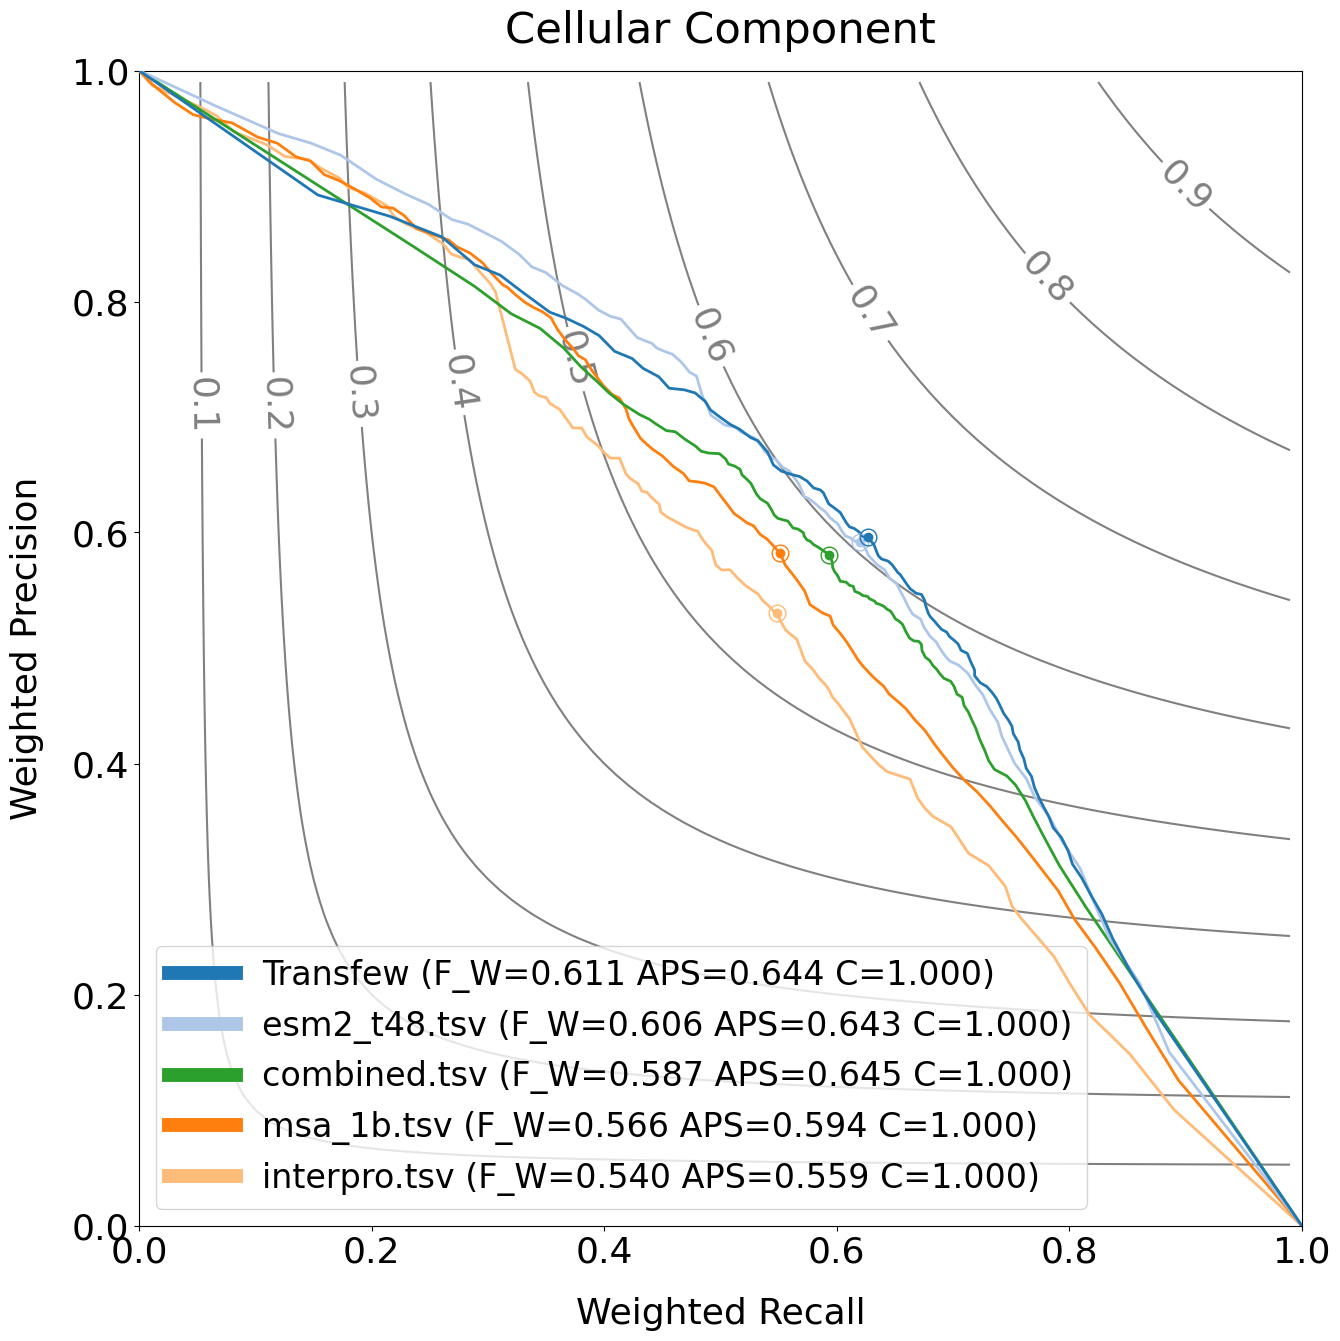

In [47]:
# Generate the figures
plt.rcParams.update({'font.size': 26, 'legend.fontsize': 24})

# F-score contour lines
x = np.arange(0.01, 1, 0.01)
y = np.arange(0.01, 1, 0.01)
X, Y = np.meshgrid(x, y)
Z = 2 * X * Y / (X + Y)

for ns, df_g in df_best.groupby(level='ns'):
    fig, ax = plt.subplots(figsize=(15, 15))

     # Contour lines. At the moment they are provided only for the F-score
    if metric.startswith('f'):
        CS = ax.contour(X, Y, Z, np.arange(0.1, 1.0, 0.1), colors='gray')
        ax.clabel(CS, inline=True) #, fontsize=10)

    # Iterate methods
    for i, (index, row) in enumerate(df_g.sort_values(by=[metric, 'max_cov'], ascending=[False if metric.startswith('f') else True, False]).iterrows()):
        data = df_methods.loc[index[:-1]]
        
        # Precision-recall or mi-ru curves
        ax.plot(data[cols[0]], data[cols[1]], color=row['colors'], label=row['label'], lw=2, zorder=500-i)
        
        # F-max or S-min dots
        ax.plot(row[cols[0]], row[cols[1]], color=row['colors'], marker='o', markersize=12, mfc='none', zorder=1000-i)
        ax.plot(row[cols[0]], row[cols[1]], color=row['colors'], marker='o', markersize=6, zorder=1000-i)

    # Set axes limit
    if metric.startswith('f'):
        plt.xlim(0, 1)
        plt.ylim(0, 1)
   
    # plt.xlim(0, max(1, df_best.loc[:,:,ns,:][cols[0]].max()))
    # plt.ylim(0, max(1, df_best.loc[:,:,ns,:][cols[1]].max()))

    # Set titles
    ax.set_title(ontology_dict.get(ns, ns), pad=20)
    ax.set_xlabel(axis_title_dict[cols[0]], labelpad=20)
    ax.set_ylabel(axis_title_dict[cols[1]], labelpad=20)
    
    # Legend
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    leg = ax.legend(markerscale=6)
    for legobj in leg.get_lines():
        legobj.set_linewidth(10.0)

    # Save figure on disk
    plt.savefig("{}/fig_{}_{}.png".format(out_folder, metric, ns), bbox_inches='tight', dpi=300, transparent=True)
    # plt.clf()